In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import datetime
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

import tensorflow as tf
print("TF version: ", tf.__version__)

2025-06-13 16:36:35.545824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749832595.732987      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749832595.793641      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version:  2.18.0


General Information Regarding Data

In [3]:
train_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
train_df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [4]:
train_df = train_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis = 1)
train_df.head()

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


In [5]:
filenames = ['/kaggle/input/gtsrb-german-traffic-sign/' + fname for fname in train_df['Path']]
filenames[:10]

['/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00001.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00002.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00003.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00004.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00005.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00006.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00007.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00008.png',
 '/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00009.png']

In [7]:
labels = train_df['ClassId'].to_numpy()
labels

unique_signs = np.unique(labels)
len(unique_signs)

# Converting the labels into one hot encoding
labels = tf.keras.utils.to_categorical(labels, 43)
labels[0]
len(labels)

39209

In [8]:
# Create X & y variables
X = filenames
y = labels

# Splitting our data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(y_train), len(X_val), len(y_val)

(31367, 31367, 7842, 7842)

Preprocessing the Data

In [9]:
IMG_SIZE = 32

def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_png(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (32, 32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

In [10]:
def get_image_label (image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and reutrns a typle of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [11]:
BATCH_SIZE = 64

# Create a function to turn data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation dat
    a.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training dataset batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image) and turning into batches
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [12]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

Creating training dataset batches...
Creating validation dataset batches...


I0000 00:00:1749832662.945185      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float64, name=None)))

Training Batch


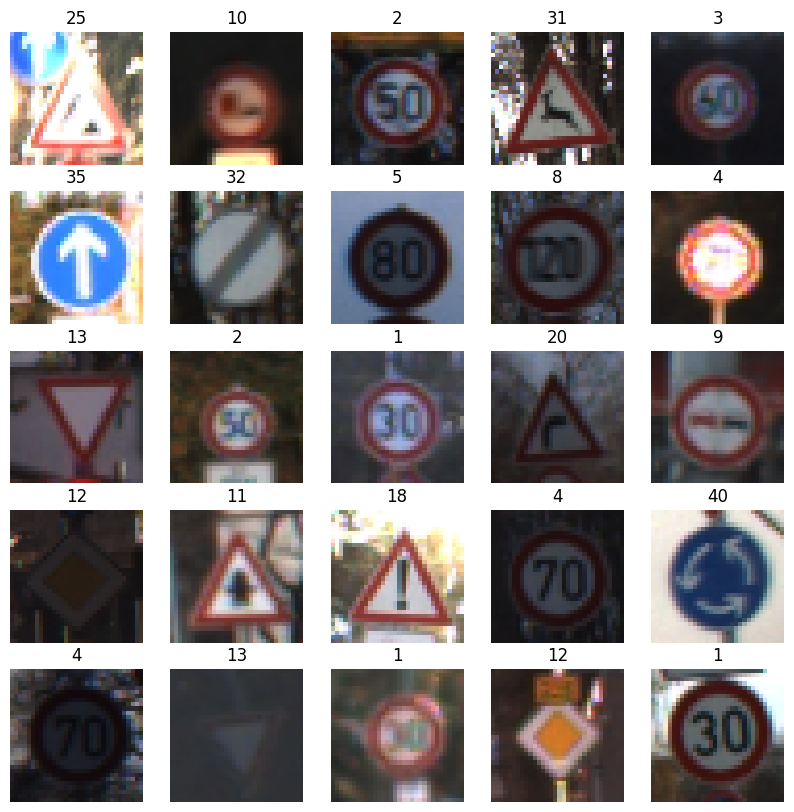

In [17]:
def show_25_images (images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_signs[labels[i].argmax()])
        plt.axis("off")
        
# Visualizing traing batch
print("Training Batch")
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)



Testing Batch


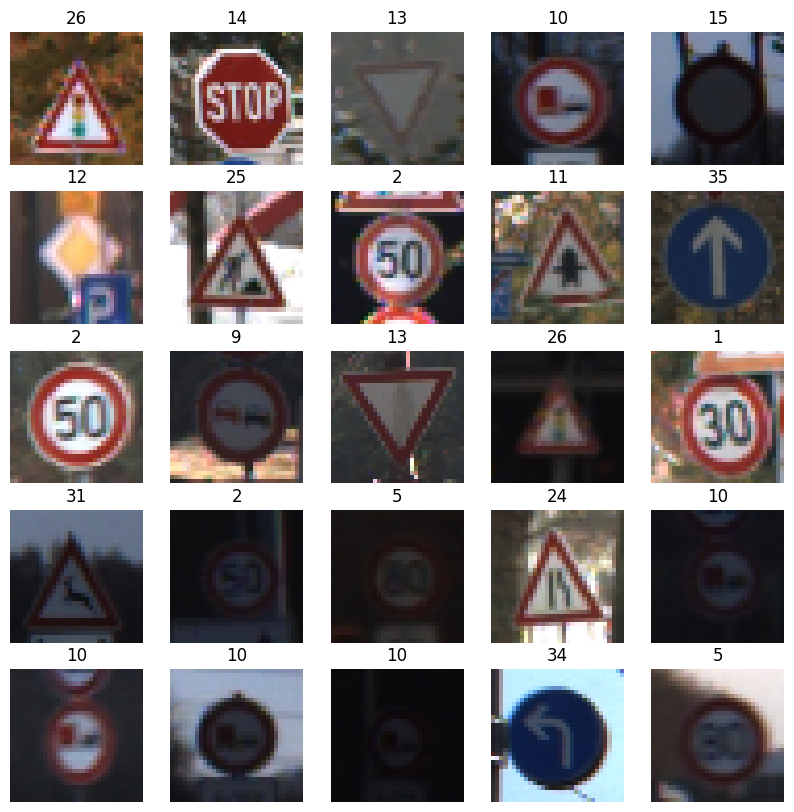

In [18]:
# Visualizing validation data

val_images, val_labels = next(val_data.as_numpy_iterator())
print("Testing Batch")
show_25_images(val_images, val_labels)

MODEL

In [19]:
# Setup input shape to the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

# Setup the output shape
OUTPUT_SHAPE = len(unique_signs)

Model Architecture

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import HeNormal

def traffic_sign_net(input_shape):
    initializer = HeNormal()
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Classification
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    return model


In [23]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Setup the model layers
    model = traffic_sign_net(input_shape=input_shape)
    # Compile the model
    print("Compiling the model")
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling the model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 256)           │              

 Total params: 1,226,859 (4.68 MB)

 Trainable params: 1,224,555 (4.67 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [26]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import FileLink

# Define the checkpoint file path
CHECKPOINT_PATH = "best_model.weights.h5"

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Setup the model layers
    model = traffic_sign_net(input_shape=input_shape)

    # Compile the model
    print("Compiling the model")
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

# Callback for saving best model weights
checkpoint_cb = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    model.summary()

    # Fit the model
    model.fit(
        x=train_data,
        epochs=50,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[checkpoint_cb]
    )

    # Load best weights before returning
    model.load_weights(CHECKPOINT_PATH)

    return model

# Train the model
model = train_model()

# Make the weights downloadable in Kaggle
print("Training complete. Download link for model weights:")
FileLink(CHECKPOINT_PATH)


Compiling the model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 8, 8, 256)           │              

 Total params: 1,226,859 (4.68 MB)

 Trainable params: 1,224,555 (4.67 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/50


I0000 00:00:1749832998.696963      93 service.cc:148] XLA service 0x785f64008970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749832998.697650      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749832999.455139      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/491 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.0212 - loss: 4.4313   

I0000 00:00:1749833005.451693      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2362 - loss: 2.8942
Epoch 1: val_accuracy improved from -inf to 0.74828, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 106s 187ms/step - accuracy: 0.2366 - loss: 2.8925 - val_accuracy: 0.7483 - val_loss: 0.8874
Epoch 2/50
489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8833 - loss: 0.4162
Epoch 2: val_accuracy improved from 0.74828 to 0.96289, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8835 - loss: 0.4155 - val_accuracy: 0.9629 - val_loss: 0.1207
Epoch 3/50
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9753 - loss: 0.0977
Epoch 3: val_accuracy improved from 0.96289 to 0.99311, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9754 - loss: 0.0977 - val_accuracy: 0.9931 - val_loss: 0.0291
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9829 - loss: 0.0633
Epoch 4: val_accuracy di

/kaggle/working/best_model.weights.h5

Testing Dataset

In [28]:
test_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_df = test_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)
test_df.head()

test_img_paths = ['/kaggle/input/gtsrb-german-traffic-sign/' + path for path in test_df['Path']]
test_img_paths[:10]

X_test = create_data_batches(test_img_paths, test_data=True)
y_test = list(test_df['ClassId'])
y_test[:10]

Creating test data batches...


[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

In [29]:
predictions = model.predict(X_test, verbose=1)

def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_signs[np.argmax(prediction_probabilities)]
    
# Turning probabilities to labels
pred_labels = []
for i in predictions:
    pred_labels.append(get_pred_label(i))
pred_labels[:10]

198/198 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step


[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

In [30]:
acc = accuracy_score(y_test, pred_labels)
acc

0.9855106888361045